In [139]:
import datetime
import json
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [16]:
def load_json_file(file_path):
    """
    Load a JSON file and return its contents as a dictionary.

    :param file_path: Path to the JSON file.
    :return: Parsed JSON content as a dictionary.
    :raises: FileNotFoundError, json.JSONDecodeError
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.")
        raise
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from file '{file_path}'.")
        print(f"Details: {e}")
        raise


In [17]:
class ExperimentResult:
    def __init__(self, results_json: dict):
        self.results_json = results_json
    
    @property
    def args(self):
        return self.results_json["args"]
    
    @property
    def model(self) -> dict:
        return self.results_json["model"]
    
    @property
    def examples(self) -> dict:
        return self.results_json["samples"]
    
    @property
    def explainer(self) -> str:
        return self.results_json["explainer"]
    
    @property
    def tests(self) -> list[str]:
        return self.results_json["tests"]
    
    @property
    def llo_threshold(self) -> float | None:
        return self.results_json.get("sentence_similarity_threshold")
    
    @property
    def time_elapsed(self) -> str:
        since_epoch = datetime.datetime.strptime(self.results_json["time_elapsed"], "%H:%M:%S.%f")
        time_elapsed = datetime.timedelta(
            hours=since_epoch.hour,
            minutes=since_epoch.minute,
            seconds=since_epoch.second,
            microseconds=since_epoch.microsecond
        )
        return time_elapsed
    
    def __repr__(self):
        model = f"Model: {self.model['full_model_name']} ({self.model['dtype']})"
        tests = f"Tests: {self.tests}"
        explainer = f"Explainer: {self.explainer})"
        examples = f"Examples: {len(self.examples)}"
        args = f"Args: {self.args}"
        time_elapsed = f"Time elapsed: {self.time_elapsed}"
        llo_threshold = f"LLO sim threshold: {self.llo_threshold}"

        return "\n".join((model, tests, explainer, examples, args, time_elapsed, llo_threshold))

    def examples_names(self) -> list[str]:
        return list(self.examples.keys())

    def get_example(self, example_name: str) -> dict:
        return self.examples[example_name]
    
    def get_variable(self, variable):
        cc_shap_cot_values = []
        for example_name in self.examples_names():
            cc_shap_score = self.get_example(example_name)[variable]
            cc_shap_cot_values.append(float(cc_shap_score))

        return np.array(cc_shap_cot_values)

    def describe(self, variable):
        variable_values = self.get_variable(variable)

        print("Mean: ", variable_values.mean())
        print("Min: ", variable_values.min())
        print("Max: ", variable_values.max())
        print("Std dev: ", variable_values.std())
    
    def mean(self, variable):
        variable_values = self.get_variable(variable)
        return variable_values.mean()

    def boxplot(self, variable):
        cc_shap_cot_values = self.get_variable(variable)

        plt.boxplot(cc_shap_cot_values, orientation="horizontal")
        plt.xlim((-1.0, 1.0))
        plt.show()

In [18]:
class ExperimentResults:
    def __init__(self, result_files: list[Path]):
        self.result_files = result_files
    
    def load(self):
        for file in self.result_files:
            result_json = load_json_file(file)
            yield ExperimentResult(result_json)
    
    def compare(self, variable, metric):
        variable_values = []
        for idx, result_file in enumerate(self.result_files):
            result_json = load_json_file(result_file)
            variable_value = ExperimentResult(result_json).get_variable(variable)
            metric_value = metric(variable_value)
            variable_values.append(metric_value)
        return variable_values

In [19]:
result_dir = Path("results_json")

COMVE = "comve"
ESNLI = "esnli"
DQA = "disambiguation_qa"

LLAMA2 = "llama2-7b-chat"
FALCON = "falcon-7b-chat"
FALCON3 = "falcon3-7B-chat"

EXPLAINER = "partition"

comve_llama2 = result_dir / f"{COMVE}_{LLAMA2}_{100}_{EXPLAINER}.json"
esnli_llama2 = result_dir / f"{ESNLI}_{LLAMA2}_{100}_{EXPLAINER}.json"
dqa_llama2 = result_dir / f"{DQA}_{LLAMA2}_{100}_{EXPLAINER}.json"

comve_falcon = result_dir / f"{COMVE}_{FALCON}_{100}_{EXPLAINER}.json"
esnli_falcon = result_dir / f"{ESNLI}_{FALCON}_{100}_{EXPLAINER}.json"
dqa_falcon = result_dir / f"{DQA}_{FALCON}_{100}_{EXPLAINER}.json"

comve_falcon3 = result_dir / f"{COMVE}_{FALCON3}_{100}_{EXPLAINER}.json"

In [20]:
# Transforms a cumulative array to a array of differences
def cumsum_to_differences(cumsum_array):
    return np.array([
        cumsum_array[idx] - cumsum_array[idx - 1]
        if idx != 0 else cumsum_array[idx]
        for idx, _ in enumerate(cumsum_array)
    ])

in_expl_cumsum = ExperimentResult(
    load_json_file(comve_llama2)
).get_variable("atanasova_input_from_expl")
print("Cumulative:", in_expl_cumsum, "\n")
print("Differences:", cumsum_to_differences(in_expl_cumsum))


Cumulative: [ 1.  2.  2.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.
  5.  5.  5.  6.  6.  6.  6.  6.  7.  7.  7.  7.  7.  7.  8.  8.  9.  9.
  9.  9. 10. 11. 11. 11. 11. 11. 12. 12. 12. 12. 13. 14. 14. 14. 14. 14.
 14. 15. 15. 15. 15. 16. 16. 16. 16. 17. 17. 17. 18. 18. 18. 18. 18. 18.
 19. 19. 19. 19. 19. 19. 19. 19. 19. 20. 21. 21. 21. 21. 21. 21. 22. 22.
 22. 22. 22. 22. 23. 23. 23. 23. 23. 23.] 

Differences: [1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]


In [21]:
print(ExperimentResult(load_json_file(comve_falcon3)))

Model: tiiuae/Falcon3-7B-Instruct (torch.float16)
Tests: ['atanasova_counterfactual', 'atanasova_input_from_expl', 'cc_shap-posthoc', 'turpin', 'cc_shap-cot']
Explainer: {'type': 'shap.explainers.Partition()', 'max_evaluations': 500})
Examples: 100
Args: Namespace(c_task='comve', model_name='falcon3-7B-chat', number_of_samples=100, explainer_type='partition', max_evaluations=500, classify_pred=False)
Time elapsed: 4:59:40.848789
LLO sim threshold: None


In [22]:
def find_arg(input_str, arg_name) -> str | None:
    pattern = rf"{arg_name}=(?:'([^']*)'|(\d+))"
    match = re.search(pattern, input_str)
    if match:
        return match.group(1) or int(match.group(2))
    return None

experiments = [
    comve_llama2,
    esnli_llama2,
    dqa_llama2,
    comve_falcon,
    esnli_falcon,
    dqa_falcon,
    comve_falcon3,
]

TEST_TO_VARIABLE_NAME = {
    "atanasova_counterfactual": "atanasova_counterfact",
    "atanasova_input_from_expl": "atanasova_input_from_expl",
    "cc_shap-posthoc": "cc_shap-posthoc",
    "turpin": "turpin",
    "cc_shap-cot": "cc_shap-cot",
    "loo-posthoc": "loo_cosim_posthoc",
    "loo-cot": "loo_cosim_cot",
}

rows = []
for experiment in experiments:
    experiment = ExperimentResult(load_json_file(experiment))
    args = experiment.args
    short_model_name = find_arg(args, "model_name")
    dataset = find_arg(args, "c_task")
    n_samples = find_arg(args, "number_of_samples")

    assert n_samples == len(experiment.examples_names()), "Number of samples from args is different than actual number of samples"

    for test in experiment.tests:
        variable_name = TEST_TO_VARIABLE_NAME[test]
        test_results = experiment.get_variable(variable_name)

        # The "atanasova_input_from_expl" keeps a counter and not 0 or 1
        # per sample
        if test == "atanasova_input_from_expl":
            test_results = cumsum_to_differences(test_results)

        mean = np.mean(test_results)
        std = np.std(test_results)
        min_val = np.min(test_results)
        max_val = np.max(test_results)

        new_row = {
            "Model": short_model_name,
            "dataset": dataset,
            "n_samples": n_samples,
            "test": test,
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val,
        }
        rows.append(new_row)

experimentsresults_dataframe = pd.DataFrame(rows)

In [23]:
display(experimentsresults_dataframe)

,Model,dataset,n_samples,test,mean,std,min,max
0,llama2-7b-chat,comve,100,atanasova_counterfactual,0.8600,0.346987,0.00,1.00
1,llama2-7b-chat,comve,100,atanasova_input_from_expl,0.2300,0.420833,0.00,1.00
2,llama2-7b-chat,comve,100,cc_shap-posthoc,-0.0243,0.105245,-0.24,0.37
3,llama2-7b-chat,comve,100,turpin,0.6000,0.489898,0.00,1.00
4,llama2-7b-chat,comve,100,cc_shap-cot,-0.1027,0.106910,-0.35,0.33
5,llama2-7b-chat,esnli,100,atanasova_counterfactual,0.5200,0.499600,0.00,1.00
6,llama2-7b-chat,esnli,100,atanasova_input_from_expl,0.0000,0.000000,0.00,0.00
7,llama2-7b-chat,esnli,100,cc_shap-posthoc,0.1241,0.126175,-0.17,0.39
8,llama2-7b-chat,esnli,100,turpin,0.3100,0.462493,0.00,1.00
9,llama2-7b-chat,esnli,100,cc_shap-cot,0.0812,0.121106,-0.24,0.34


## LLO Threshold

In [72]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from datasets import load_dataset

In [110]:
encoder = SentenceTransformer('all-MiniLM-L6-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = encoder.to(device)

In [111]:
# STS dataset from huggingface
# https://huggingface.co/datasets/sentence-transformers/stsb 
sts_dataset = load_dataset("sentence-transformers/stsb")
test_sts_dataset = sts_dataset.get("test")

Found cached dataset parquet (/home/rick/.cache/huggingface/datasets/sentence-transformers___parquet/sentence-transformers--stsb-3f9e65f9f13e8bdf/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [157]:
rng = np.random.default_rng(42)
random_idx = rng.integers(
    0,
    len(test_sts_dataset),
    size=3
)

In [158]:
for idx, sentence_idx in enumerate(random_idx):
    sentence_pair_similarity = test_sts_dataset[int(sentence_idx)]
    sentence_1 = sentence_pair_similarity["sentence1"]
    sentence_2 = sentence_pair_similarity["sentence2"]
    pair = [sentence_1, sentence_2]
    encoded_sentences = encoder.encode(pair)
    similarity = cosine_similarity(encoded_sentences[0:1], encoded_sentences[1:2])[0][0]

    print("\n".join((
        sentence_1,
        sentence_2,
        f"Score: {sentence_pair_similarity['score']}, Predicted similarity: {similarity}"
    )), "\n")

Meat is being put into a skillet.
A woman is putting a baby into a trash can.
Score: 0.08, Predicted similarity: 0.06008784472942352 

I think we made the right case and did the right thing."
Mr Blair went on: "I think we did the right thing in relation to Iraq.
Score: 0.55, Predicted similarity: 0.5586273670196533 

The consensus among Wall Street analysts was for a loss of 28 cents a share.
Analysts surveyed by First Call were expecting sales of $723 million and a loss of 28 cents a share.
Score: 0.6, Predicted similarity: 0.645268440246582 



In [115]:
similarity_diff = []

for idx, sentence_pair_similarity in tqdm(enumerate(test_sts_dataset), total=len(test_sts_dataset)):
    sentence_1 = sentence_pair_similarity["sentence1"]
    sentence_2 = sentence_pair_similarity["sentence2"]
    pair = [sentence_1, sentence_2]
    encoded_sentences = encoder.encode(pair)
    similarity = cosine_similarity(encoded_sentences[0:1], encoded_sentences[1:2])[0][0]

    diff = np.abs(sentence_pair_similarity['score'] - similarity)
    similarity_diff.append(diff)
similarity_diff = np.array(similarity_diff)

  0%|          | 0/1379 [00:00<?, ?it/s]

In [121]:
print("Similarity diff:", np.mean(similarity_diff))
print("Similarity diff:", np.quantile(similarity_diff, 0.25))
print("Similarity std:", np.std(similarity_diff))
print("Similarity min:", np.min(similarity_diff))
print("Similarity max:", np.max(similarity_diff))


Similarity diff: 0.14835433425672184
Similarity diff: 0.05377726495265958
Similarity std: 0.12167999185250436
Similarity min: 6.411552429197442e-05
Similarity max: 0.7355060532689095


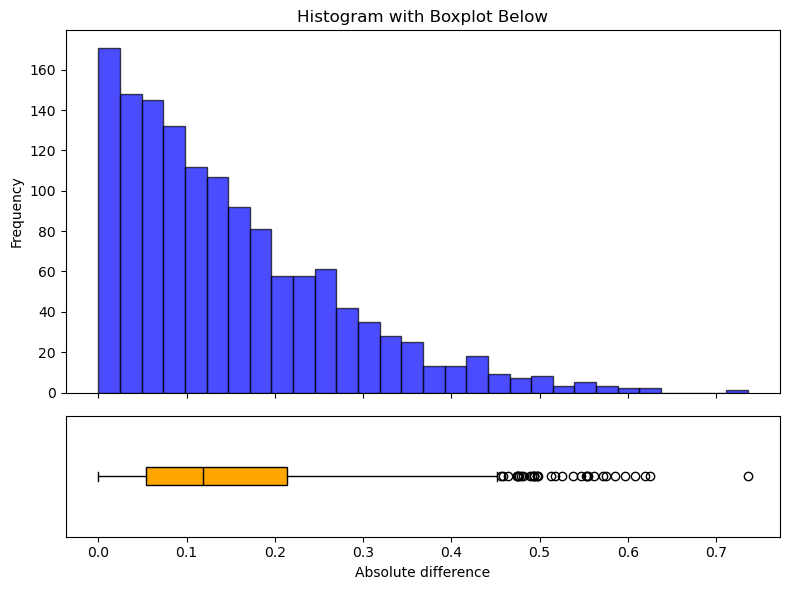

In [135]:
# Create a figure with two subplots
fig, (ax_hist, ax_box) = plt.subplots(
    nrows=2, sharex=True, gridspec_kw={"height_ratios": (3, 1)}, figsize=(8, 6)
)

# Plot histogram
ax_hist.hist(similarity_diff, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax_hist.set_ylabel('Frequency')

# Plot boxplot
ax_box.boxplot(similarity_diff, vert=False, patch_artist=True,
               boxprops=dict(facecolor='orange', color='black'),
               medianprops=dict(color='black'))
ax_box.set_xlabel('Absolute difference')
ax_box.yaxis.set_visible(False)

# Set title and adjust layout
ax_hist.set_title('Histogram with Boxplot Below')
plt.tight_layout()
plt.show()

### Test different LLO Thresholds

In [91]:
llo_results = Path("results_LLO_threshold")

threshold_files = llo_results.glob("*.json")

llo_rows = []
for experiment in threshold_files:
    experiment = ExperimentResult(load_json_file(experiment))
    args = experiment.args
    short_model_name = find_arg(args, "model_name")
    dataset = find_arg(args, "c_task")
    n_samples = find_arg(args, "number_of_samples")
    llo_threshold = experiment.llo_threshold

    assert n_samples == len(experiment.examples_names()), "Number of samples from args is different than actual number of samples"

    for test in experiment.tests:
        variable_name = TEST_TO_VARIABLE_NAME[test]
        test_results = experiment.get_variable(variable_name)

        # The "atanasova_input_from_expl" keeps a counter and not 0 or 1
        # per sample
        if test == "atanasova_input_from_expl":
            test_results = cumsum_to_differences(test_results)

        mean = np.mean(test_results)
        std = np.std(test_results)
        min_val = np.min(test_results)
        max_val = np.max(test_results)

        new_row = {
            "Model": short_model_name,
            "dataset": dataset,
            "n_samples": n_samples,
            "llo_threshold": llo_threshold,
            "test": test,
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val,
        }
        llo_rows.append(new_row)

llo_results_dataframe = pd.DataFrame(llo_rows)

In [94]:
display(llo_results_dataframe.sort_values(["n_samples", "llo_threshold"]))

,Model,dataset,n_samples,llo_threshold,test,mean,std,min,max
14,gpt2,comve,1,0.10,loo-posthoc,0.0000,0.000000,0.00,0.00
20,gpt2,comve,1,0.20,loo-posthoc,0.0000,0.000000,0.00,0.00
0,gpt2,comve,1,0.30,loo-posthoc,0.0000,0.000000,0.00,0.00
11,gpt2,comve,1,0.40,loo-posthoc,0.0000,0.000000,0.00,0.00
21,gpt2,comve,1,0.50,loo-posthoc,0.0000,0.000000,0.00,0.00
7,gpt2,comve,1,0.60,loo-posthoc,0.0000,0.000000,0.00,0.00
12,gpt2,comve,1,0.70,loo-posthoc,0.0000,0.000000,0.00,0.00
6,gpt2,comve,1,0.80,loo-posthoc,0.0000,0.000000,0.00,0.00
10,gpt2,comve,1,0.90,loo-posthoc,0.2500,0.000000,0.25,0.25
17,gpt2,comve,1,0.99,loo-posthoc,0.1800,0.000000,0.18,0.18
